##Malaria dataset
La malaria (o paludismo) es una enfermedad causada por un parásito Plasmodium, el cual es trasmitido por la picadura de un mosquito infectado.

El conjunto de datos de Malaria contiene un total de 27.558 imágenes de células con instancias iguales de células parasitadas y no infectadas de las imágenes de diapositivas de frotis de sangre delgada de células segmentadas.

In [1]:
# Diagnóstico de Malaria
!wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/MalariaCells.zip \
 -O /tmp/MalariaCells.zip

--2023-01-16 00:36:12--  https://storage.googleapis.com/platzi-tf2/MalariaCells.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.250.103.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 547750600 (522M) [application/zip]
Saving to: ‘/tmp/MalariaCells.zip’

/tmp/MalariaCells.z 100%[===================>] 522.38M   139MB/s    in 3.8s    

2023-01-16 00:36:16 (137 MB/s) - ‘/tmp/MalariaCells.zip’ saved [547750600/547750600]



## Descomprimir la base de datos y almacenarla en carpetas training y test
El siguiente código de Python usará la biblioteca del sistema operativo para usar las bibliotecas del sistema operativo, lo que le dará acceso al sistema de archivos y la biblioteca ZipFile le permitirá descomprimir los datos.

En el siguiente código de Python utilizamos la libreria OS para poder dar acceso a los archivos del sistema operativo y luego con la librería ZipFile descomprimimos la base de datos.

In [2]:
import os
import zipfile

local_zip = "/tmp/MalariaCells.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/tmp/MalariaCells")
zip_ref.close()

CARGAMOS LAS LIBRERIAS NECESARIAS

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Buscamos la dirección de nuestra base de datos
En este caso la base de datos esta distruibuida en training y test. Cada carpeta contiene otra subcarpeta en donde se tiene cada una de las clases de la base de datos.

In [4]:
train_dir = "/tmp/MalariaCells/Train"
test_dir = "/tmp/MalariaCells/Test"

In [5]:
train_dir

'/tmp/MalariaCells/Train'

## Data Generators
Configuremos generadores de datos que leerán imágenes en nuestras carpetas de origen, las convertirán en tensores `float32` y las alimentarán (con sus etiquetas) a nuestra red. Tendremos un generador para las imágenes de entrenamiento y otro para las imágenes de validación. Nuestros generadores producirán lotes de imágenes de tamaño 142x148 y sus etiquetas (clases lenguaje de señas).

In [6]:
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255, validation_split= 0.2)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (142, 148),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "training"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (142, 148),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (142, 148),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale"
)

Found 27558 images belonging to 2 classes.
Found 3166 images belonging to 2 classes.
Found 15832 images belonging to 2 classes.


DEFINIMOS LAS CLASES DE NUESTRA BASE DE DATOS

In [8]:
classes = ['Parasitized','Uninfected']

Visualizamos los datos

In [9]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0])
    ax.axis("off")
  plt.tight_layout()
  plt.show()

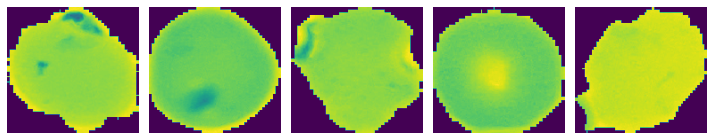

In [10]:
sample_training_images, _= next(train_generator)
plotImages(sample_training_images[:5])

##CREAMOS NUESTRO MODELO CONVOLUCIONAL 1

In [14]:
from tensorflow.keras import regularizers
model_callback_convolutional = tf.keras.models.Sequential([
              tf.keras.layers.Conv2D(64, (3,3), activation = "relu", input_shape= (142, 148, 1)),
              tf.keras.layers.MaxPool2D((2,2)),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(128, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(256, kernel_regularizer= regularizers.l2(1e-5),activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(len(classes), activation = "sigmoid")
])

model_callback_convolutional.summary()

model_callback_convolutional.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history_convolutional_1 = model_callback_convolutional.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 140, 146, 64)      640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 70, 73, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 327040)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               41861248  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                      

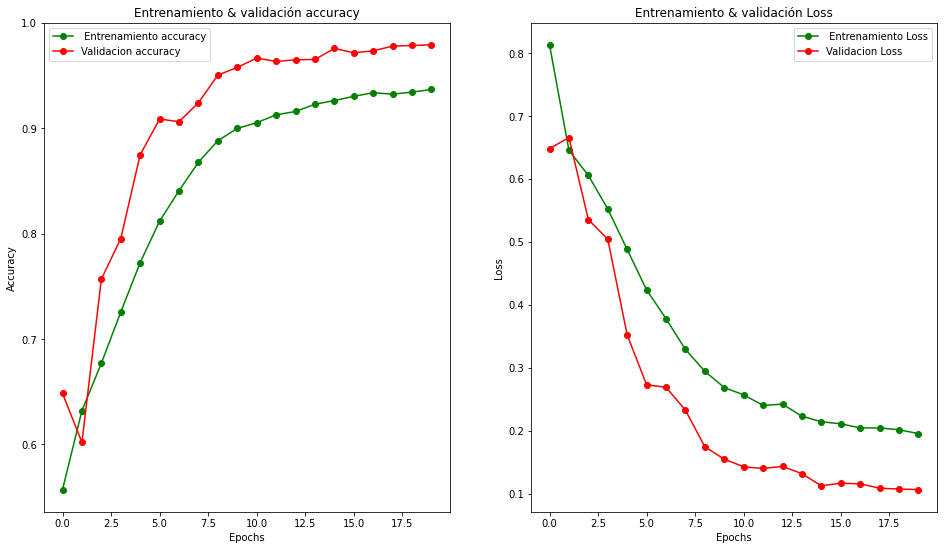

In [15]:
def visualizacion_resultados(history):
  epochs = [i for i in range(20)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(epochs, train_acc, "go-", label =" Entrenamiento accuracy")
  ax[0].plot(epochs, val_acc, "ro-", label= "Validacion accuracy")
  ax[0].set_title("Entrenamiento & validación accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs, train_loss, "go-", label =" Entrenamiento Loss")
  ax[1].plot(epochs, val_loss, "ro-", label= "Validacion Loss")
  ax[1].set_title("Entrenamiento & validación Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()
visualizacion_resultados(history_convolutional_1)

In [20]:
results = model_callback_convolutional.evaluate(test_generator)

124/124 [==============================] - 20s 157ms/step - loss: 0.1051 - accuracy: 0.9840


Usar el formato .h5 para guardar modelos.
Hierarchical Data Format (HDF5 format)

In [21]:
model_callback_convolutional.save("my_model.h5")